In [1]:
import numpy as np
from skimage import io, color, feature, measure
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import cv2

import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import numpy as np
from tqdm import tqdm
import skimage

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [3]:
# Load the VGG-19 model pre-trained on ImageNet
model = models.vgg19(pretrained=True)
# Define a new feature extractor that outputs the style features
class StyleExtractor(nn.Module):
    def __init__(self):
        super(StyleExtractor, self).__init__()
        self.features = nn.Sequential(
            *list(model.features.children())[:35]
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

style_extractor = StyleExtractor()

def style_extractor(photo_path,style_extractor=style_extractor):

    # Load the image and apply the necessary transformations
    img = Image.open(photo_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img).unsqueeze(0)

    # Extract the style features from the image

    style_features = style_extractor(img_tensor).squeeze()

    return style_features



/Users/chenyangkang/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chenyangkang/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [68]:
style_extractor(photo_path)

tensor([-4.4940, -6.5953, -5.6175,  ...,  2.2431,  2.8086,  0.9505],
       grad_fn=<SqueezeBackward0>)

In [4]:
listings = pd.read_csv('LA_Airbnb/listings_detailed.csv')
room_codes = [i.split('/')[-1] for i in listings['listing_url'].values]

In [5]:
from warnings import filterwarnings
filterwarnings('ignore')

In [7]:
room_image_features = {}
for room_code in tqdm(room_codes):
    try:
        photos = os.listdir(f'LA_photos/{room_code}')
    except:
        continue
    
    features = {
        "size":[],
        "sharpness":[],
        "mean_brightness":[],
        "contrast":[],
        "dissimilarity":[],
        "homogeneity":[],
        "energy":[],
        "correlation":[],
        "num_contours":[],
        "area":[],
        "perimeter":[],
        "num_edges":[],
        "num_contours":[],
        "hist":[],
    }
    for photo in photos:
        try:
            photo_path = f'LA_photos/{room_code}/{photo}'

            # Load the image
            img = cv2.imread(photo_path)

            # size
            size = img.shape[0] * img.shape[1]

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Compute the Laplacian of the grayscale image
            laplacian = cv2.Laplacian(gray, cv2.CV_64F)

            # Compute the sharpness of the image
            sharpness = np.var(laplacian)

            # Extract the color histogram features
            hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            hist = cv2.normalize(hist, hist).flatten()

            # Compute the mean brightness of the image
            mean_brightness = np.mean(gray)


            # Extract the texture features using gray-level co-occurrence matrix (GLCM)
            glcm = skimage.feature.graycomatrix(np.uint8(gray*255), [5], [0], 256, symmetric=True, normed=True)
            contrast = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]
            dissimilarity = skimage.feature.graycoprops(glcm, 'dissimilarity')[0, 0]
            homogeneity = skimage.feature.graycoprops(glcm, 'homogeneity')[0, 0]
            energy = skimage.feature.graycoprops(glcm, 'energy')[0, 0]
            correlation = skimage.feature.graycoprops(glcm, 'correlation')[0, 0]

            # Extract the shape features using contour detection
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            num_contours = len(contours)
            # area = cv2.contourArea(contours[0])
            # perimeter = cv2.arcLength(contours[0], True)


            # Extract the edge features using Canny edge detection
            edges = cv2.Canny(gray, 100, 200)
            num_edges = np.sum(edges > 0)

            # # Extract the HOG features
            # fd, hog_image = feature.hog(gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)


            features["size"].append(size)
            features["sharpness"].append(sharpness)
            features["mean_brightness"].append(mean_brightness)
            features["contrast"].append(contrast)
            features["dissimilarity"].append(dissimilarity)
            features["homogeneity"].append(homogeneity)
            features["energy"].append(energy)
            features["correlation"].append(correlation)
            features["num_contours"].append(num_contours)
            # features["area"].append(area)
            # features["perimeter"].append(perimeter)
            features["num_edges"].append(num_edges)
            features["num_contours"].append(num_contours)
            features["hist"].append(hist)
        except:
            continue

    mean_features = {}
    for k in features.keys():
        a = np.array(features[k])
        a = np.mean(a,axis=0)

        mean_features[k] = a

    room_image_features[room_code] = mean_features



  0%|          | 30/40438 [00:16<7:50:56,  1.43it/s]Premature end of JPEG file
Premature end of JPEG file
  3%|▎         | 1208/40438 [14:02<17:34:47,  1.61s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
  4%|▍         | 1618/40438 [18:20<4:34:45,  2.35it/s] libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
100%|██████████| 40438/40438 [32:46<00:00, 20.57it/s]   


In [47]:
pickle.dump(room_image_features, open('Boston_images_features.pkl','wb'))

In [44]:
photos

['2215762_2.jpg', '2215762_3.jpg', '2215762_1.jpg', '2215762_0.jpg']

In [32]:
mean_features

{'size': 3015475.2,
 'sharpness': 881.8978426826416,
 'mean_brightness': 150.8828161960178,
 'contrast': 673.910121676791,
 'dissimilarity': 12.238381718254388,
 'homogeneity': 0.2560129469354067,
 'energy': 0.05442209253670159,
 'correlation': 0.9010742809114989,
 'num_contours': 5510.2,
 'area': 0.0,
 'perimeter': 1.2,
 'num_edges': 104760.6,
 'hist': array([1.05827585e-01, 1.28214983e-02, 1.25080033e-03, 1.28702389e-03,
        7.05105718e-04, 8.83929315e-05, 0.00000000e+00, 0.00000000e+00,
        1.16916215e-02, 3.74532677e-02, 1.66112126e-03, 4.15854563e-04,
        2.75587809e-04, 3.45039662e-05, 5.81119480e-07, 0.00000000e+00,
        1.81599830e-06, 2.66043236e-03, 2.95695127e-03, 1.59471447e-03,
        7.56440568e-04, 1.81163981e-04, 2.17919791e-07, 0.00000000e+00,
        0.00000000e+00, 5.54780127e-06, 4.06130770e-04, 9.26591165e-04,
        8.06075346e-04, 7.86545221e-04, 8.56424813e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.07507094e-0

In [26]:
a.shape

(512,)

In [19]:
fd.shape


(221184,)

In [8]:
contrast

710.1634587952396

In [87]:
hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])

In [88]:
hist.shape

(8, 8, 8)

In [81]:
laplacian = cv2.Laplacian(gray1, cv2.CV_64F).var()


In [82]:
laplacian

0.0038976234132965183

In [76]:
gray1

array([[0.99607843, 0.99215686, 0.98823529, ..., 0.80656431, 0.79872118,
        0.79479961],
       [1.        , 0.99607843, 0.99215686, ..., 0.80739765, 0.80347608,
        0.79955451],
       [0.99607843, 0.99215686, 0.99215686, ..., 0.80739765, 0.80739765,
        0.80739765],
       ...,
       [0.05185137, 0.0479298 , 0.04400824, ..., 0.46238   , 0.47081137,
        0.50807765],
       [0.0479298 , 0.0479298 , 0.04400824, ..., 0.41334902, 0.41477059,
        0.43608275],
       [0.0479298 , 0.0479298 , 0.04400824, ..., 0.3587298 , 0.37414824,
        0.41336392]])

In [72]:
gray

array([[254, 253, 252, ..., 205, 203, 202],
       [255, 254, 253, ..., 205, 204, 203],
       [254, 253, 253, ..., 205, 205, 205],
       ...,
       [ 13,  12,  11, ..., 118, 120, 129],
       [ 12,  12,  11, ..., 106, 106, 111],
       [ 12,  12,  11, ...,  92,  96, 106]], dtype=uint8)

In [46]:
perimeter

0.0

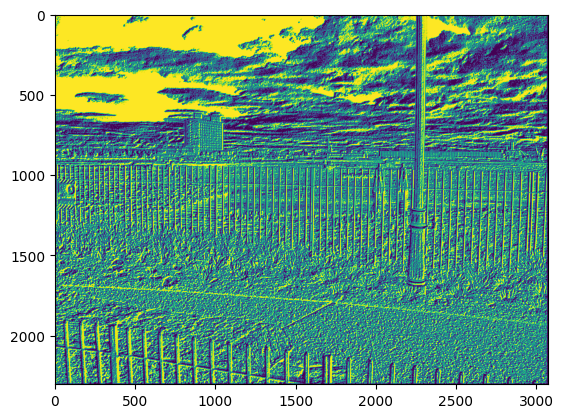

In [40]:
plt.imshow(lbp)

In [34]:
hog[1].shape,hog[0].shape

((2304, 3072), (8849412,))

In [18]:
gray.max()

1.0

In [8]:
photos

['3781_4.jpg', '3781_0.jpg', '3781_1.jpg', '3781_3.jpg', '3781_2.jpg']

In [ ]:
# Load the image
img = io.imread('image.jpg')

# Convert the image to grayscale
gray = color.rgb2gray(img)

# Compute the color histogram
hist, _ = np.histogram(img, bins=256, range=(0, 255))